# DG Schemes [(Notebook)][1]

[1]: _downloads/laplace-dg.ipynb
show the
- dgscheme
- galerkin schemes

Let us consider a simple Laplace problem with Dirichlet boundary conditions:
\begin{equation*}
  \begin{aligned}
    -\Delta u &= \sin(\pi x_1) \sin(\pi x_2) && \text{in $\Omega$}, \\
            u &= 0 && \text{on $\partial\Omega$}.
  \end{aligned}
\end{equation*}

First, we need to set up a computational grid and a discontinuous ansatz space on it. Here, we use the orthonormal discontinuous space:

In [1]:
try:
    %matplotlib inline # can also use notebook or nbagg
except:
    pass
from dune.grid import cartesianDomain
from dune.fem import parameter
from dune.fem.plotting import plotPointData as plot

import dune.create as create

parameter.append({"fem.verboserank": 0, "istl.preconditioning.method": "ilu", "istl.preconditioning.iterations": 1, "istl.preconditioning.relaxation": 1.2})

grid = create.grid("ALUConform", cartesianDomain([0,0],[1,1],[16,16]), dimgrid=2)
spc = create.space("dgonb", grid, dimrange=1, order=2, storage="istl")

2018-06-12 00:02:21,341 - dune.common - INFO - MPI initialized successfully
2018-06-12 00:02:21,425 - dune.common.module - INFO - Using existing dune-py module in /home/dedner/Envs/dune3/.cache/dune-py
2018-06-12 00:02:21,431 - dune.generator.builder - INFO - using pre configured dune-py module
2018-06-12 00:02:21,710 - dune.create - INFO - Importing create registries from [ dune.femnv dune.functions dune.grid dune.fem dune.alugrid dune.vem ]
2018-06-12 00:02:21,711 - dune.generator.builder - INFO - Loading HierarchicalGrid
2018-06-12 00:02:21,847 - dune.generator.builder - INFO - Loading ReferenceElements
2018-06-12 00:02:21,959 - dune.generator.builder - INFO - Loading ReferenceElements
2018-06-12 00:02:22,069 - dune.generator.builder - INFO - Loading ReferenceElements
2018-06-12 00:02:22,184 - dune.generator.builder - INFO - Loading Space


The classical IPDG method for this problem reads
\begin{equation*}
  \int_\Omega \nabla u\,\nabla \varphi\,dx
    - \int_\Gamma ([[u]] \otimes \vec{n} : \{\{\nabla \varphi\}\} + \{\{\nabla u\}\} : [[\varphi]] \otimes \vec{n}\,dx
    + \int_\Gamma \frac{\mu}{h} [[u]] [[\varphi]]
    = 0.
\end{equation*}

The following code implements this equation in UFL notation:

In [2]:
import math
from ufl import *

from dune.ufl import Space

uflSpace = Space((grid.dimGrid, grid.dimWorld), 1)
u = TrialFunction(uflSpace)
v = TestFunction(uflSpace)
x = SpatialCoordinate(uflSpace.cell())
n, h = FacetNormal(uflSpace.cell()), MinFacetEdgeLength(uflSpace.cell())
mu = 7.5 / avg(h)

a = inner(grad(u), grad(v)) * dx
a -= (inner(outer(jump(u), n('+')), avg(grad(v))) + inner(avg(grad(u)), outer(jump(v), n('+')))) * dS
a += mu * inner(jump(u), jump(v)) * dS
a -= (inner(outer(u, n), grad(v)) + inner(grad(u), outer(v, n))) * ds
a += mu * inner(u, v) * ds

b = sin(pi*x[0])*sin(pi*x[1])*v[0]*dx

Next, we compile this into the *integrands*, plug them into the *galerkin* scheme and solve the problem:

In [3]:
model = create.model("integrands", grid, a == b)

newtonParameter = {"linabstol": 1e-13, "linreduction": 1e-13, "tolerance": 1e-12, "verbose": "true", "linear.verbose": "false"}
scheme = create.scheme("galerkin", spc, model, parameters={"fem.solver.newton." + k: v for k, v in newtonParameter.items()})

uh, _ = scheme.solve()

2018-06-12 00:02:55,794 - dune.generator.builder - INFO - Loading integrands (new)
2018-06-12 00:03:15,688 - dune.generator.builder - INFO - Loading Scheme (updated)
2018-06-12 00:04:38,640 - dune.generator.builder - INFO - Loading DiscreteFunction (new)


The result looks as follows:

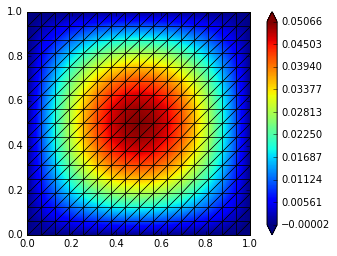

In [4]:
plot(uh)